# Imports

In [1]:
# Please update the default location as you deem fit
cvml_path = '/home/alex.li/git/JupiterCVML/europa/base/src/europa'

In [2]:
import json
import cv2
import os
import multiprocessing as mp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dl.utils.io_utils import normalize_image

%matplotlib inline
from cv.core.image_quality_server_side import ImageQuality

# from cv.core.image_quality_server_side_halo import ImageQuality
from dl.utils.config import DEFAULT_TONEMAP_PARAMS

## Datasets

In [3]:
dataset_idx = 0
directory = ['/data/jupiter/datasets/bad_iq_halo_labelbox_plus_exposure', '/data2/jupiter/datasets/20231017_halo_rgb_labeled_excluded_bad_iq', '/data/jupiter/datasets/iq_2023_v5_anno'][dataset_idx]
csv_name = ['654a5bb2e89875bddc714dd2_master_annotations.csv', '653a7a0a3c2d8ab221f6d915_master_annotations.csv','64dfcc1de5a41169c7deb205_master_annotations.csv'][dataset_idx]

dset_name = directory.split('/')[-1]
save_path='/mnt/sandbox1/alex.li/iq_results'

side_left_tire_mask = f'{cvml_path}/cv/core/tire_masks/side_left_iq_mask.png'
side_right_tire_mask = f'{cvml_path}/cv/core/tire_masks/side_right_iq_mask.png'
stereo_df_full = pd.read_csv(os.path.join(directory, csv_name), low_memory=False)
stereo_df = stereo_df_full.drop_duplicates(['id'])[:10000]

# Prediction from JupiterCVML repo

In [4]:
iq = ImageQuality(num_workers=mp.cpu_count() // 3,
                  use_progress=True,
                  side_left_tire_mask_path = side_left_tire_mask,
                  side_right_tire_mask_path = side_right_tire_mask,
                  normalization_params=DEFAULT_TONEMAP_PARAMS,
                  dataset=dset_name,
                  save_path=save_path)
out = pd.value_counts(stereo_df['camera_location'])
for i, v in zip(out.index, out.values):
    print(f"{i},{v}")

T10,2870
T09,1892
T02,1714
T01,994
T05,552
I01,498
T14,405
T13,280
I02,189
T06,141


In [5]:
output_path = f'{save_path}/{dset_name}'
output_file = f'{output_path}/iq.csv'
skip_cache = False
if (not os.path.exists(output_file)) or (skip_cache):
    labeled = iq.from_df(stereo_df, directory, use_progress=True)
else:
    df = pd.read_csv(output_file)

/home/alex.li/miniconda3/envs/cvml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (23,24,25,26,27,29,30,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
if not os.path.exists(output_file) or skip_cache:
    labeled['iq'] = labeled.image_quality.apply(lambda x: x.algorithm_output)
    labeled['iq_features'] = labeled.image_quality.apply(lambda x: x.algorithm_features)
    labeled['iq_features_total'] = labeled.iq_features.apply(lambda x: x['image_features']['total'])
    labeled['iq_features_low'] = labeled.iq_features.apply(lambda x: x['image_features']['low'])
    labeled['iq_features_mid'] = labeled.iq_features.apply(lambda x: x['image_features']['mid'])
    labeled['iq_features_high'] = labeled.iq_features.apply(lambda x: x['image_features']['high'])
    labeled['iq_features_depth_ratio'] = labeled.iq_features.apply(lambda x: x['image_features']['depth_ratio'])
    labeled['iq_features_smudge'] = labeled.iq_features.apply(lambda x: x['image_features']['smudge'])
    labeled['iq_features_smudge_reason'] = labeled.iq_features.apply(lambda x: x['image_features']['smudge_reason'])
    labeled['iq_process_time'] = labeled.image_quality.apply(lambda x: x.algorithm_process_time)

    if 'iq_ground_truth' in labeled:
        labeled['binary_iq'] = labeled.iq.apply(lambda x: 'iq' if x != 'good' else 'non_iq')
        labeled['binary_iq_ground_truth'] = labeled.iq_ground_truth.apply(lambda x: 'iq' if x != 'good' else 'non_iq')

    output_path = f'{save_path}/{dset_name}'
    output_file = f'{output_path}/iq.csv'
    os.makedirs(name=output_path, exist_ok=True)
    labeled.to_csv(output_file)

    labeled.iq.value_counts()
    df = pd.read_csv(f"{output_path}/iq.csv")

In [7]:
for k in df.iq.value_counts().keys():
    print(k, sum(df.iq == k))
    print(','.join(sorted(list(set(df[(df.iq == k)]['id'])))))

good 5838
6441ff440c5bcfd4f0c73d80,644200bff9706c0922456463,64420291fb7e8d35a3daa280,644210d5e80424019283e6c7,644211ed9483e5fbaaa8314a,64421813c167bcf5bda98d82,6442192cbef8363a7c354580,64422658242be814b7ae67e7,64422866e80424019284087e,64422e8b28d7da9cfdfade91,6442333b0b6121f98b08486a,64ae6a4b300726b19422019d,64ae72265ff7a72a1cad11ab,64ae733b2267229a9b255c0e,64ae759a9cec289c2f21bd12,64ae79192267229a9b256d05,64ae7f3451621889c928d71d,64ae894151621889c928f97d,64ae894d42a627809b8f8d31,64ae899596da59a3f4bcd8c7,64aea112fe7d8883e38d7c39,64aea21a51621889c9294642,64aea62196da59a3f4bd2f83,64aea6532ffbb8c9feb3a5a7,64aeb365235017ddd0e08d64,64aeb870fe7d8883e38dc276,64aeb8842267229a9b261a1d,64aebd47235017ddd0e0a2e8,64aebdcb235017ddd0e0a473,64aebfbdbe3ada6dacb42bba,64aecf74edd2cf97d08831c3,64aed9755ff7a72a1cae2e73,64aed9952267229a9b267706,64aedac19cec289c2f2280c7,64aedca3edd2cf97d0884c2e,64aedd02c06ead6d4ad1ad5b,64aede22c06ead6d4ad1b13a,64aedf379cec289c2f228a62,64aee08abf952f152b47965b,64aee091e0a80bb

In [8]:
# keys = [k for k in df.iq.value_counts().keys() if k != 'smudge']
# ncols = 40
# cats = [df[df.iq == k].sample(min(ncols, sum(df.iq==k))) for k in keys]
# page = 0
# cols_per_row = 10
# rows_per_cat = (cols_per_row - 1 + ncols) // cols_per_row
# nrows = len(cats) * rows_per_cat
# fig, ax = plt.subplots(nrows, cols_per_row, figsize=(cols_per_row * 3.2, nrows * 4))
# for i, subdf in enumerate(cats):
#     ax[i * rows_per_cat][0].set_title(f"{keys[i]} ({sum(df.iq == keys[i])} images)")
#     print(keys[i])
#     for j in range(0, ncols, 5):
#         print(','.join(subdf['id'][j:j+5]))
#     for j in range(ncols):
#         if j >= len(subdf):
#             break
#         folder_path  = directory + "/processed/images/" + subdf.iloc[j]['id'] + "/"
#         file_name = os.listdir(folder_path)[0]
#         obj = np.load(folder_path + file_name)
#         im = normalize_image(obj['left'], subdf.iloc[j]['hdr_mode'])
#         ax[i * rows_per_cat + j // cols_per_row][j % cols_per_row].imshow(im)
#         if j!=0:
#             ax[i * rows_per_cat + j // cols_per_row][j % cols_per_row].set_title(subdf.iloc[j]['id'])

4


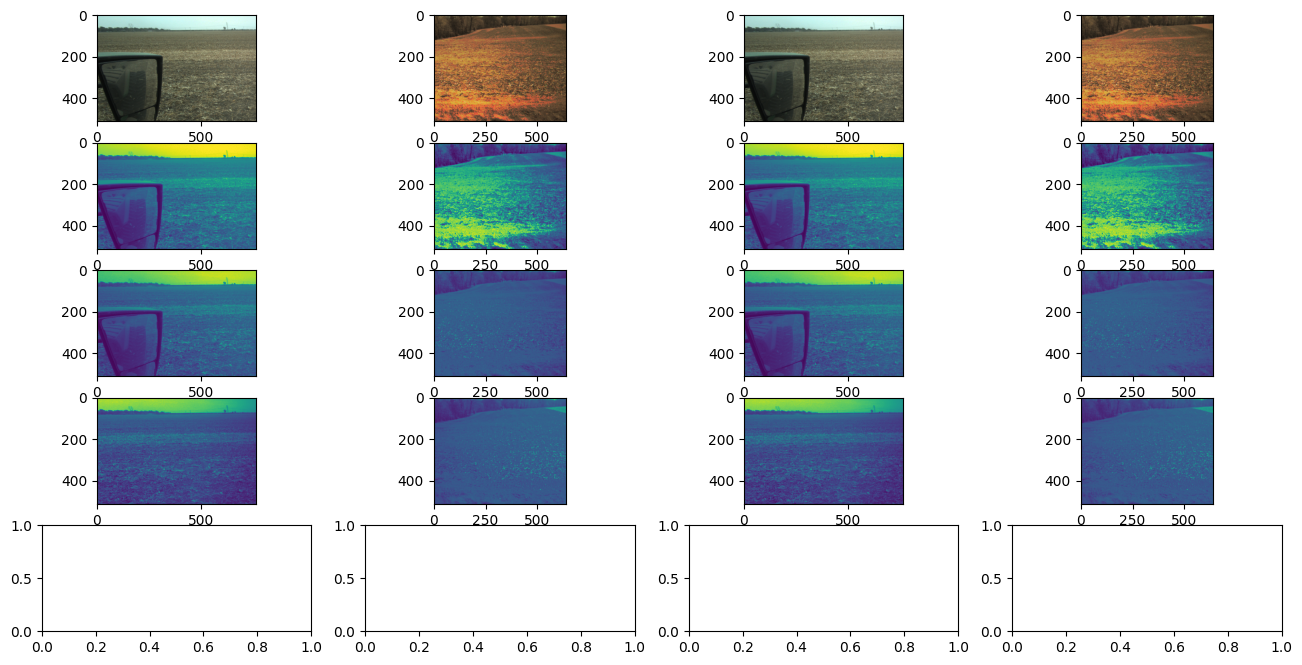

In [9]:
import cv2
label_iq_list = {
    'good': ['64e6934deef031aa465115f3'],
    'smudge': ['64f252dd09cc4b4e291c3d92'],
    'bright': ['65314ed92d57fffd7b5f58dc','65314328aa24e4fe413727a9','6531432ed16de083ddcd9e6f'],
    'dark': ['61e2123ec474d19dd1fa2a4a', '61b40e3b98b541cea45c5301', '61e20d373779e1599ea89ae9', '61b405a3b285dcddd6842e09', '61b4197ef2f41a5e365faa2f'],
    'misc': ['650b67d42760cd80b1fb0f89','64422e8b28d7da9cfdfade91'],
}
iq_type_df = stereo_df_full[stereo_df_full['id'].isin(label_iq_list['misc'])]
print(len(iq_type_df))
if len(iq_type_df):    
    fig, ax = plt.subplots(5, len(iq_type_df), figsize=(3.2  * 5, 2 * len(iq_type_df)), squeeze=False)
    for j in range(len(iq_type_df)):
        folder_path  = directory + "/processed/images/" + iq_type_df.iloc[j]['id'] + "/"
        file_name = os.listdir(folder_path)[0]
        obj = np.load(folder_path + file_name)
        im_l = normalize_image(obj['left'], iq_type_df.iloc[j]['hdr_mode'])
        im_r = normalize_image(obj['right'], iq_type_df.iloc[j]['hdr_mode'])
        left_hsl_img = cv2.cvtColor(im_l, code=cv2.COLOR_RGB2HSV).copy()
        right_hsl_img = cv2.cvtColor(im_r, cv2.COLOR_RGB2HSV).copy()
        left_gray = left_hsl_img[:, :, 2]
        right_gray = right_hsl_img[:, :, 2]

        left_saturation = left_hsl_img[:, :, 1]
        right_saturation = right_hsl_img[:, :, 1]

        ax[0][j].imshow(im_l)
        ax[1][j].imshow(left_gray)
        ax[2][j].imshow(left_gray * (1 - left_saturation))
        ax[3][j].imshow(right_gray * (1 - right_saturation))
    plt.show()

In [10]:
if len(iq_type_df):
    iq_debug = ImageQuality(num_workers=1,
                    use_progress=False,
                    side_left_tire_mask_path = side_left_tire_mask,
                    side_right_tire_mask_path = side_right_tire_mask,
                    normalization_params=DEFAULT_TONEMAP_PARAMS,
                    dataset=dset_name,    
                    save_path=save_path)
    res = iq_debug.from_df(iq_type_df, directory).copy()
    res['iq'] = res.image_quality.apply(lambda x: x.algorithm_output)

/home/alex.li/miniconda3/envs/cvml/lib/python3.8/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/home/alex.li/miniconda3/envs/cvml/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [11]:
# keys = ['good', 'smudge']
# ncols = 40
# cats = [df[df.iq == k].sample(ncols) for k in keys]
# page = 0
# show_depth = False
# col_per_image = (3 if show_depth else 2)
# cols_per_row = 3 * col_per_image
# rows_per_cat = (cols_per_row - 1 + ncols) // cols_per_row
# nrows = len(cats) * rows_per_cat
# fig, ax = plt.subplots(nrows, cols_per_row, figsize=(cols_per_row * 3.2, nrows * 4))
# for i, subdf in enumerate(cats):
#     print(f"{keys[i]}: ({sum(df.iq == keys[i])} images)")
#     for j in range(0, ncols, cols_per_row//col_per_image):
#         print(','.join(subdf['id'][j:j+cols_per_row//col_per_image]))
#         if show_depth:
#             ax[i * rows_per_cat][j+2].set_title(f"depth")
#     for j in range(0, ncols, col_per_image):
#         if j // 2 >= len(subdf):
#             break
#         row = subdf.iloc[j // col_per_image]
#         folder_path  = directory + "/processed/images/" + row['id'] + "/"
#         # assert len(os.listdir(folder_path)) == 1, os.listdir(folder_path)
#         file_name = os.listdir(folder_path)[0]
#         obj = np.load(folder_path + file_name)
#         im_l = normalize_image(obj['left'], row['hdr_mode'])
#         im_r = normalize_image(obj['right'], row['hdr_mode'])
#         im_depth = obj['point_cloud'][..., 2] / 100
#         ax[i * rows_per_cat + j // cols_per_row][j % cols_per_row].set_title(row['id'])
#         ax[i * rows_per_cat + j // cols_per_row][(j + 1)% cols_per_row].set_title(row['iq_features_smudge_reason'])
#         ax[i * rows_per_cat + j // cols_per_row][j % cols_per_row].imshow(im_l)
#         ax[i * rows_per_cat + (j + 1) // cols_per_row][(j + 1) % cols_per_row].imshow(im_r)
#         if show_depth:
#             ax[i * rows_per_cat + (j + 2) // cols_per_row][(j + 2) % cols_per_row].imshow(im_depth)

## Accuracy Metrics
#### Valid only if ground-truth image_quality_labels exist

In [12]:
def accuracy(df, iq_type='overall'):
    if iq_type!='overall':
        sub_df = df[df.iq_ground_truth==iq_type]
    else:
        sub_df = df
    valid = np.sum(sub_df.iq == sub_df.iq_ground_truth)
    total = len(sub_df)
    acc = valid/total if total != 0 else 0
    print(f'{iq_type}\tproperly-predicted:{valid:4d} \ttotal-images:{total:4d}\tacc:{100*acc:.3f}%')

if 'iq_ground_truth' in df:
    accuracy(df, 'smudge')  
    accuracy(df, 'dark')
    accuracy(df, 'bright')  
    accuracy(df, 'good') 
    accuracy(df, 'overall')
    valid = np.sum(df.binary_iq == df.binary_iq_ground_truth)
    total = len(df)
    acc = valid/total
    print(f'IqNonIq\tproperly-predicted:{valid:4d} \ttotal-images:{total:4d}\tacc:{100*acc:.3f}%')

In [13]:
# OG
# smudge	properly-predicted: 252 	total-images: 342	acc:73.684%
# dark	properly-predicted: 279 	total-images: 284	acc:98.239%
# bright	properly-predicted: 266 	total-images: 426	acc:62.441%
# good	properly-predicted:   0 	total-images:   5	acc:0.000%
# overall	properly-predicted: 797 	total-images:1057	acc:75.402%
# IqNonIq	properly-predicted: 964 	total-images:1057	acc:91.202%

In [15]:
# import ast
# exposure_time_sec = ast.literal_eval(row['calibration_data'])['exposure_ms'][0] / 1000

In [17]:
sub_df = pd.read_parquet('~/logs/iq_analysis.parquet')

FileNotFoundError: [Errno 2] No such file or directory: '/home/alex.li/logs/iq_analysis.parquet'

In [18]:
import tqdm
sub_df = df.copy()
brightness_gray_at_p = []
brightness_hsl_at_p = []
brightness_hdr_at_p = []
brightness_hdr_lo_at_p = []
for i in range(100):
    brightness_gray_at_p.append([])
    brightness_hsl_at_p.append([])
    brightness_hdr_at_p.append([])
    brightness_hdr_lo_at_p.append([])
for _, row in tqdm.tqdm(iterable=sub_df.iterrows(), total=len(sub_df)):
    # print(row['id'])
    folder_path  = directory + "/processed/images/" + row['id'] + "/"
    file_name = os.listdir(folder_path)[0]
    obj = np.load(folder_path + file_name)
    im_l = normalize_image(obj['left'], row['hdr_mode'], iq.normalization_params) * 255
    left_gray_img = np.int32(cv2.cvtColor(im_l, cv2.COLOR_RGB2GRAY))
    left_hsl_img = np.int32(cv2.cvtColor(im_l, code=cv2.COLOR_RGB2HSV)[:,:,2])
    lo_gray = 25 if row['operation_time'] == 'daytime' else 40
    lo_hsl = 25 if row['operation_time'] == 'daytime' else 75
    # print(np.max(left_hsl_img))
    # print(np.sum((left_hsl_img) > 150))
    for i, val in enumerate(iterable=list(np.percentile(left_gray_img, range(100)))):
        brightness_gray_at_p[i].append(val)
    for i, val in enumerate(iterable=list(np.percentile(left_hsl_img, range(100)))):
        brightness_hsl_at_p[i].append(val)
    hdr_gray = obj['left'][:,:,0] * .2126 + obj['left'][:,:,1] * .7152 + obj['left'][:,:,2] * .0722
    for i, val in enumerate(iterable=list(np.percentile(hdr_gray, range(100)))):
        brightness_hdr_at_p[i].append(val)
    H, W, C = obj['left'].shape
    l = obj['left'][H//2:,:,:]
    hdr_gray_lo = l[:,:,0] * .2126 + l[:,:,1] * .7152 + l[:,:,2] * .0722
    for i, val in enumerate(iterable=list(np.percentile(hdr_gray_lo, range(100)))):
        brightness_hdr_lo_at_p[i].append(val)
for i in range(100):
    sub_df[f'gray_{i}'] = brightness_gray_at_p[i]
    sub_df[f'hsl_{i}'] = brightness_hsl_at_p[i]
    sub_df[f'hdr_{i}'] = brightness_hdr_at_p[i]
    sub_df[f'hdrlo_{i}'] = brightness_hdr_lo_at_p[i]
sub_df = sub_df.copy()
sub_df.to_parquet('~/logs/iq_analysis.parquet')

  0%|          | 0/9535 [00:00<?, ?it/s]

 72%|███████▏  | 6880/9535 [19:37<07:41,  5.75it/s]

/tmp/ipykernel_284738/2738457322.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[f'gray_{i}'] = brightness_gray_at_p[i]
/tmp/ipykernel_284738/2738457322.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[f'hsl_{i}'] = brightness_hsl_at_p[i]
/tmp/ipykernel_284738/2738457322.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fra

In [29]:
def show_images(cats, bright_quantity, percentile):
    ncols = 20
    cols_per_row = 5
    rows_per_cat = (cols_per_row - 1 + ncols) // cols_per_row
    nrows = len(cats) * rows_per_cat
    fig, ax = plt.subplots(nrows, cols_per_row, figsize=(cols_per_row * 3.2, nrows * 4))
    for i, subdf in enumerate(cats):
        for j in range(ncols):
            if j >= len(subdf):
                break
            folder_path  = directory + "/processed/images/" + subdf.iloc[j]['id'] + "/"
            file_name = os.listdir(folder_path)[0]
            obj = np.load(folder_path + file_name)
            im = normalize_image(obj['left'], subdf.iloc[j]['hdr_mode'])
            ax[i * rows_per_cat + j // cols_per_row][j % cols_per_row].imshow(im)
            ax[i * rows_per_cat + j // cols_per_row][j % cols_per_row].set_title(f"{bright_quantity}@{percentile}%:{subdf.iloc[j][f'{bright_quantity}_{percentile}']:.2}")
            # ax[i * rows_per_cat + j // cols_per_row][j % cols_per_row].set_title(f"{percentile}% gray{int(subdf.iloc[j][f'gray_{percentile}'])}hsl{int(subdf.iloc[j][f'hsl_{percentile}'])}hdr{int(subdf.iloc[j][f'hdr_{percentile}'])}")

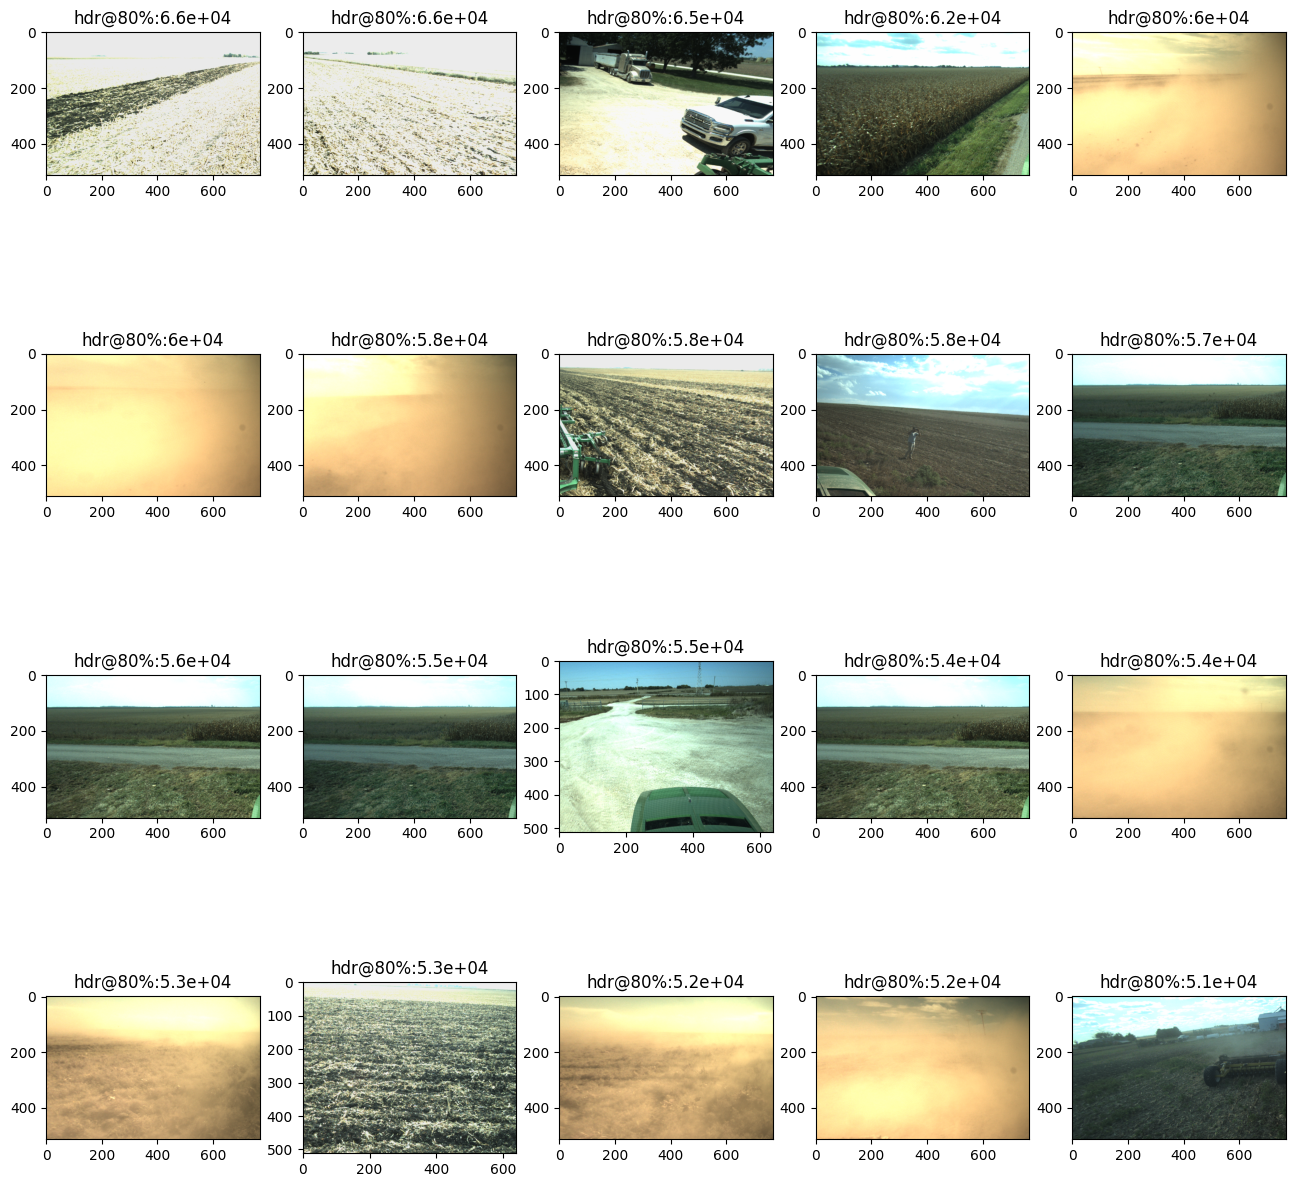

In [25]:
bright_quantity = ['gray','hsl','hdr'][2]
percentile = 80
largest = True
sub_df = sub_df.sort_values(f'{bright_quantity}_{percentile}')
if percentile < 50:
    cats = [sub_df[::2]]
else:
    cats = [sub_df[::-2]]
show_images(cats, bright_quantity, percentile)

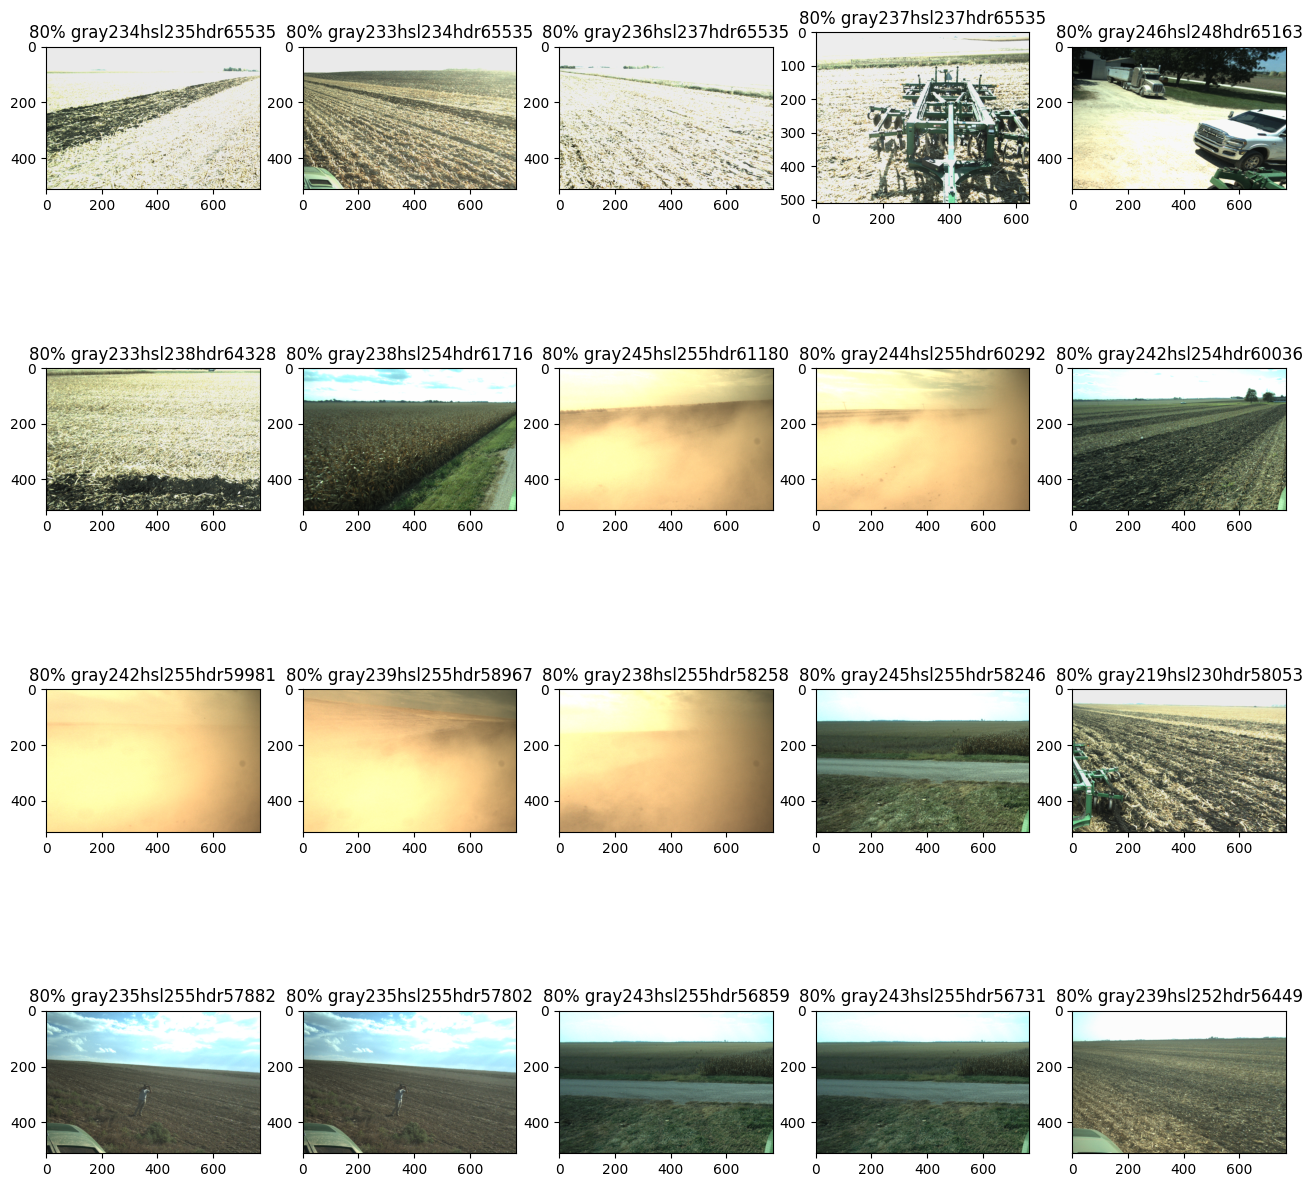

In [31]:
bright_images = sub_df[sub_df['hdr_80'] > 2e4]
show_images([bright_images[::-1]], 'gray', percentile)